# yFiles

This example demonstrates how the NetworkX-Graph created by PT3S can be used with yFiles.

# PT3S Release

In [1]:
#pip install PT3S -U --no-deps

# Imports

In [2]:
import os
import geopandas
from geopandas import GeoSeries
import logging
import pandas as pd
import io

import subprocess

import matplotlib.pyplot as plt

import matplotlib
import matplotlib.colors as mcolors

import folium
from folium.plugins import HeatMap

import networkx as nx

import typing
from yfiles_jupyter_graphs import GraphWidget

try:
    from PT3S import dxAndMxHelperFcts
except:
    import dxAndMxHelperFcts
    
try:
    from PT3S import Mx
except:
    import Mx

try:
    from PT3S import Rm
except:
    import Rm

In [3]:
import importlib

In [4]:
#importlib.reload(dxAndMxHelperFcts)

# Logging

In [5]:
logger = logging.getLogger()  

logFileName= r"Example6.log" 

loglevel = logging.DEBUG
logging.basicConfig(filename=logFileName
                        ,filemode='w'
                        ,level=loglevel
                        ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s")    

fileHandler = logging.FileHandler(logFileName)     

logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# Read Model and Results

In [6]:
dbFilename="Example6"
dbFile=os.path.join(os.path.dirname(os.path.abspath(dxAndMxHelperFcts.__file__))
                    +'/Examples/'
                    +dbFilename
                    +'.db3'
)

In [7]:
m=dxAndMxHelperFcts.readDxAndMx(dbFile=dbFile,preventPklDump=True,maxRecords=0)
#NBVAL_IGNORE_OUTPUT

INFO    ; Dx.__init__: dbFile (abspath): c:\users\aUserName\3s\pt3s\Examples\Example6.db3 exists readable ...


# Network Graph

In [8]:
netNodes=[n for (n,data) in m.G.nodes(data=True) if 
    data['KVR'] in [1,'1'] # nur der VL
and data['ID_CONT']==data['IDPARENT_CONT'] # nur das Netz
]

In [9]:
GNet=m.G.subgraph(netNodes)

In [10]:
nx.number_connected_components(GNet)

1

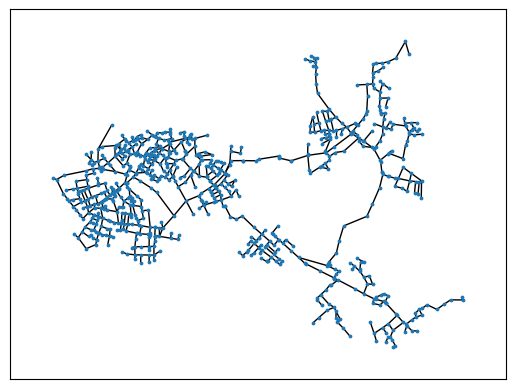

In [11]:
nx.draw_networkx(GNet,with_labels = False,node_size=3,pos=m.nodeposDctNx)

## Graph's nodes and edges in terms of raw data

In [12]:
dfEdges=m.V3_VBEL.reset_index()
dfEdges=dfEdges[(dfEdges['KVR'].isin([1,'1']))             &
             (dfEdges['ID_CONT']==dfEdges['IDPARENT_CONT'])
]

In [13]:
dfNodes=m.V3_KNOT

In [14]:
dfNodes=dfNodes[(dfNodes['tk'].isin(dfEdges['fkKI'])) |
        (dfNodes['tk'].isin(dfEdges['fkKK']))
]

In [15]:
#sorted(dfNodes['NAME_PZON'].unique())

# yFile with Network Graph

In [16]:
w=GraphWidget(graph=GNet)

## set node grouping

In [17]:
w.node_parent_group_mapping = "NAME_PZON"

#1/0

## set node coordinate mapping

In [18]:
w.get_node_coordinate_mapping()

<function yfiles_jupyter_graphs.widget.GraphWidget.default_node_coordinate_mapping(index: int, node: Dict)>

In [19]:
def my_node_coordinate_mapping(node: typing.Dict):
    
    geom=GeoSeries.from_wkb([node['properties']['GEOMWKB']],crs='EPSG:25832').to_crs('EPSG:4326').geometry.iloc[0]

    lon=geom.centroid.x 
    lat=geom.centroid.y   
    return(lat,lon)

In [20]:
node=w.nodes[0]
#sorted(node['properties'])#['GEOMWKB']

In [56]:
l=[]
for node in w.nodes:
    try:
        my_node_coordinate_mapping(node)
    except:
        pass
        l.append(node['properties'])
len(l)

773

In [58]:
dfNodes.shape

(773, 126)

In [22]:
w.set_node_coordinate_mapping(my_node_coordinate_mapping)

## set edge thickness mapping

In [23]:
w.get_edge_thickness_factor_mapping()

<function yfiles_jupyter_graphs.widget.GraphWidget.default_edge_thickness_factor_mapping(index: int, edge: Dict)>

In [24]:
dfEdges=m.V3_VBEL.reset_index()
dfEdges=dfEdges[(dfEdges['KVR'].isin([1,'1']))             &
             (dfEdges['ID_CONT']==dfEdges['IDPARENT_CONT'])
]
DImin=dfEdges['DI'].min()
DImax=dfEdges['DI'].max()
norm = plt.Normalize(vmin=DImin, vmax=DImax)

line_width_factor=10
line_width_min=1

def my_edge_thickness_factor_mapping(edge: typing.Dict):
    """DI as thickness"""
    if edge['properties']['OBJTYPE']=='VENT':
        return max(line_width_min,norm(DImax)*line_width_factor) # VENTs (Valves) with max. ROHR-(Pipe-)Thickness
    else:        
        if 'DI' in edge['properties'].keys():
            if isinstance(edge['properties']['DI'],float):
                return max(line_width_min,norm(edge['properties']['DI'])*line_width_factor)
        else:
            return line_width_min

In [25]:
#df.reset_index()

In [26]:
#1/0

In [27]:
edge=w.edges[0]
#sorted(edge['properties'])

In [28]:
for edge in w.edges:
    if edge['properties']['OBJTYPE']=='VENT':
        pass
        #print('VENT', edge['properties']['NAME_CONT'])

In [29]:
my_edge_thickness_factor_mapping(edge)

3.0926013535826185

In [30]:
w.set_edge_thickness_factor_mapping(my_edge_thickness_factor_mapping)

## set edge color mapping

In [31]:
w.get_edge_color_mapping()#custom_edge_color_mapping)

<bound method GraphWidget.default_edge_color_mapping of GraphWidget(layout=Layout(height='500px', width='100%'))>

In [32]:
colors=['lightgrey', 'dimgrey']
cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors, N=256)

cMin=matplotlib.colors.to_rgb(cmap(norm(DImin)))

def my_edge_color_mapping(edge: typing.Dict):
    """DI as color"""
    if edge['properties']['OBJTYPE']=='VENT':
        return matplotlib.colors.to_rgb('red')
    else:
        if 'DI' in edge['properties'].keys():
            if isinstance(edge['properties']['DI'],float):
                return matplotlib.colors.to_rgb(cmap(norm(edge['properties']['DI'])))
        else:            
            return cMin

In [33]:
 matplotlib.colors.to_rgb('red')

(1.0, 0.0, 0.0)

In [34]:
w.set_edge_color_mapping(my_edge_color_mapping)

In [35]:
cMin

(0.8274509803921568, 0.8274509803921568, 0.8274509803921568)

In [36]:
my_edge_color_mapping(edge)

(0.6986697424067666, 0.6986697424067666, 0.6986697424067666)

In [37]:
#1/0

## set node size mapping

In [38]:
w.get_node_size_mapping()

<function yfiles_jupyter_graphs.widget.GraphWidget.default_node_size_mapping(index: int, node: Dict)>

In [39]:
def my_node_size_mapping(node: typing.Dict):
    """Select a width and height for the node"""
    pass
    width_default=55
    height_default=55
    
    if not pd.isnull(node['properties']['NAME_CONT_VKNO']):
        return  width_default,height_default
    else:
    
    
        return width_default/10.,height_default/10.
    #return 55 + 10 * (index % 5), 55 - 10 * (index % 5)

for node in w.nodes:
    if not pd.isnull(node['properties']['NAME_CONT_VKNO']):# not in [None,'']:
        print(node['properties']['NAME_CONT_VKNO'] )
    else:
        pass

In [40]:
#sorted(node['properties'])

In [41]:
w.set_node_size_mapping(my_node_size_mapping)

## set node label mapping

In [42]:
w.get_node_label_mapping()

<bound method GraphWidget.default_node_label_mapping of GraphWidget(layout=Layout(height='500px', width='100%'))>

In [43]:
def my_node_label_mapping(node: typing.Dict):
    """"""
    return {'text':node['properties']['NAME']}

In [44]:
w.set_node_label_mapping(my_node_label_mapping)

In [45]:
#dir(node)

In [46]:
#node['properties']

## set node grouping

In [47]:
#w.node_parent_group_mapping = "NAME_PZON"

In [52]:
for node in w.nodes:
    try:
        my_node_coordinate_mapping(node)
    except:
        pass
        print(node['properties'])

{'label': '9'}
{'label': '20'}
{'label': '20'}
{'label': '19'}
{'label': '13'}
{'label': '11'}
{'label': '24'}
{'label': '19'}
{'label': '21'}
{'label': '15'}
{'label': '23'}
{'label': '12'}
{'label': '16'}
{'label': '12'}
{'label': '22'}
{'label': '10'}
{'label': '21'}
{'label': '5'}
{'label': '10'}
{'label': '5'}
{'label': '11'}
{'label': '22'}
{'label': '1'}
{'label': '23'}
{'label': '17'}
{'label': '18'}
{'label': '23'}
{'label': '12'}
{'label': '25'}
{'label': '24'}
{'label': '1'}
{'label': '25'}
{'label': '12'}
{'label': '22'}
{'label': '12'}
{'label': '8'}
{'label': '19'}
{'label': '18'}
{'label': '22'}
{'label': '5'}
{'label': '19'}
{'label': '19'}
{'label': '10'}
{'label': '23'}
{'label': '5'}
{'label': '21'}
{'label': '9'}
{'label': '20'}
{'label': '5'}
{'label': '17'}
{'label': '23'}
{'label': '9'}
{'label': '20'}
{'label': '24'}
{'label': '16'}
{'label': '3'}
{'label': '21'}
{'label': '13'}
{'label': '24'}
{'label': '23'}
{'label': '17'}
{'label': '5'}
{'label': '1'}
{'labe

In [49]:
for node in w.nodes:
    try:
        my_node_size_mapping(node)
    except:
        pass
        print(node['properties'])

In [50]:
for node in w.nodes:
    try:
        my_node_label_mapping(node)
    except:
        pass
        print(node['properties'])

## show graph

In [51]:
display(w)

Exception: Could not resolve the mapping function for the given data object 
 { 
 	 {'id': 'group#18', 'properties': {'label': '18'}, 'color': '#15AFAC', 'styles': {}, 'scale_factor': 1.0, 'type': '#15AFAC', 'position': (0.0, 0.0)} 
 } 
 

GraphWidget(layout=Layout(height='800px', width='100%'))